Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


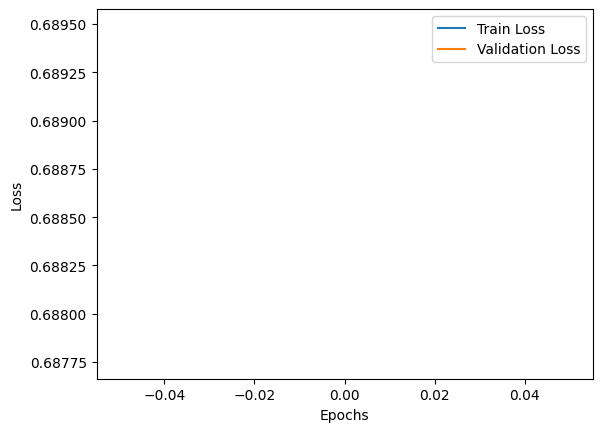

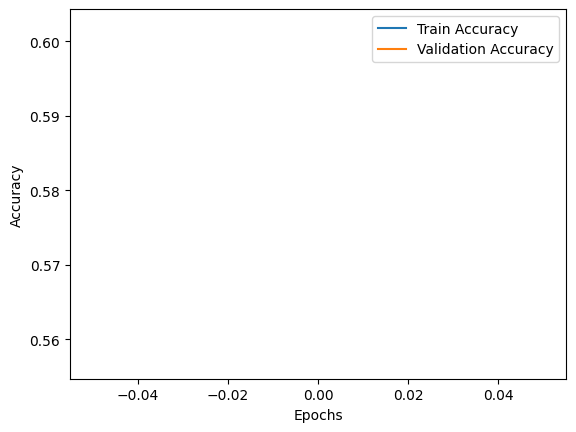

Final Train Loss: 0.6895
Final Validation Loss: 0.6878
Final Train Accuracy: 0.5570
Final Validation Accuracy: 0.6020


In [11]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Install Dependencies
!pip install torch torchvision matplotlib

# Step 3: Load and Prepare Dataset
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
import os
from PIL import Image
import numpy as np

# Define paths
data_dir = '/content/drive/MyDrive/datasetcap2/road_accident_dataset/'

# Custom Dataset class
class AccidentDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images, self.labels = self.load_images()

    def load_images(self):
        images, labels = [], []
        for label, folder in enumerate(['Non Accident', 'Accident']):
            folder_path = os.path.join(self.data_dir, folder)
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                images.append(img_path)
                labels.append(label)
        return images, labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Data transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Load and reduce dataset to 20% if necessary
full_train_dataset = AccidentDataset(data_dir + 'train', transform=transform)
train_size = int(0.2 * len(full_train_dataset))  # Reduce to 20%
train_dataset, _ = random_split(full_train_dataset, [train_size, len(full_train_dataset) - train_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = AccidentDataset(data_dir + 'val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Step 4: Define the BiLSTM Model
import torch.nn as nn

class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]
        out = self.fc(lstm_out)
        return out

# Initialize the model, loss function, and optimizer
input_dim = 128 * 3  # (height * channels)
hidden_dim = 128
output_dim = 1
model = BiLSTMModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Step 5: Train the Model
import time
num_epochs = 5
train_loss, val_loss = [], []
train_acc, val_acc = [], []

start_time = time.time()

for epoch in range(num_epochs):
    # Training loop
    model.train()
    running_loss, correct = 0.0, 0
    for inputs, labels in train_loader:
        if time.time() - start_time > 60:  # Stop training after 1 minute
            break
        inputs = inputs.permute(0, 2, 3, 1).contiguous()  # Reshape to (batch_size, height, width, channels)
        inputs = inputs.view(inputs.size(0), inputs.size(1), -1)  # Reshape to (batch_size, height, height*channels)
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.squeeze()  # Remove the extra dimension
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        preds = torch.round(torch.sigmoid(outputs))
        correct += (preds == labels).sum().item()

    train_loss.append(running_loss/len(train_loader))
    train_acc.append(correct/len(train_loader.dataset))

    # Validation loop
    model.eval()
    val_running_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.permute(0, 2, 3, 1).contiguous()  # Reshape to (batch_size, height, width, channels)
            inputs = inputs.view(inputs.size(0), inputs.size(1), -1)  # Reshape to (batch_size, height, height*channels)
            outputs = model(inputs)
            outputs = outputs.squeeze()  # Remove the extra dimension
            loss = criterion(outputs, labels.float())
            val_running_loss += loss.item()
            preds = torch.round(torch.sigmoid(outputs))
            val_correct += (preds == labels).sum().item()

    val_loss.append(val_running_loss/len(val_loader))
    val_acc.append(val_correct/len(val_loader.dataset))

    if time.time() - start_time > 60:  # Stop training after 1 minute
        break

# Save the model
torch.save(model.state_dict(), '/content/drive/MyDrive/bilstm_train.h5')

# Step 6: Plot Accuracy and Loss Curves
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Print final accuracy and loss values
print(f"Final Train Loss: {train_loss[-1]:.4f}")
print(f"Final Validation Loss: {val_loss[-1]:.4f}")
print(f"Final Train Accuracy: {train_acc[-1]:.4f}")
print(f"Final Validation Accuracy: {val_acc[-1]:.4f}")


25 percent of train

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


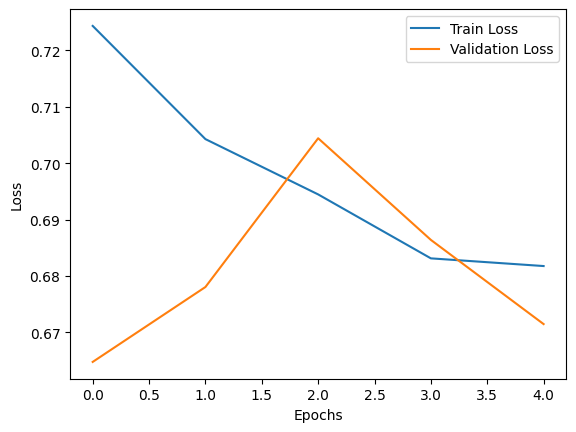

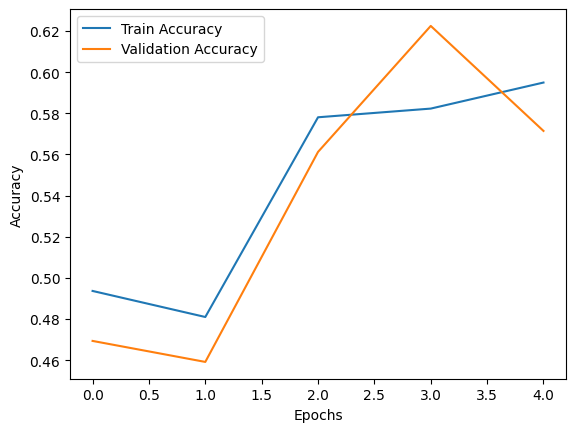

Final Train Loss: 0.6818
Final Validation Loss: 0.6715
Final Train Accuracy: 0.5949
Final Validation Accuracy: 0.5714


In [17]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Install Dependencies
!pip install torch torchvision matplotlib

# Step 3: Load and Prepare Dataset
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
import os
from PIL import Image
import numpy as np

# Define paths
data_dir = '/content/drive/MyDrive/datasetcap2/road_accident_dataset/'

# Custom Dataset class
class AccidentDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images, self.labels = self.load_images()

    def load_images(self):
        images, labels = [], []
        for label, folder in enumerate(['Non Accident', 'Accident']):
            folder_path = os.path.join(self.data_dir, folder)
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                images.append(img_path)
                labels.append(label)
        return images, labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Data transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Load and reduce dataset to 10% of the original size
full_train_dataset = AccidentDataset(data_dir + 'train', transform=transform)
train_size = int(0.30 * len(full_train_dataset))  # Reduce to 10%
train_dataset, _ = random_split(full_train_dataset, [train_size, len(full_train_dataset) - train_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = AccidentDataset(data_dir + 'val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Step 4: Define the BiLSTM Model
import torch.nn as nn

class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]
        out = self.fc(lstm_out)
        return out

# Initialize the model, loss function, and optimizer
input_dim = 128 * 3  # (height * channels)
hidden_dim = 128
output_dim = 1
model = BiLSTMModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Step 5: Train the Model
import time
num_epochs = 5
train_loss, val_loss = [], []
train_acc, val_acc = [], []

start_time = time.time()

for epoch in range(num_epochs):
    # Training loop
    model.train()
    running_loss, correct = 0.0, 0
    for inputs, labels in train_loader:
        if time.time() - start_time > 60:  # Stop training after 1 minute
            break
        inputs = inputs.permute(0, 2, 3, 1).contiguous()  # Reshape to (batch_size, height, width, channels)
        inputs = inputs.view(inputs.size(0), inputs.size(1), -1)  # Reshape to (batch_size, height, height*channels)
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.squeeze()  # Remove the extra dimension
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        preds = torch.round(torch.sigmoid(outputs))
        correct += (preds == labels).sum().item()

    train_loss.append(running_loss/len(train_loader))
    train_acc.append(correct/len(train_loader.dataset))

    # Validation loop
    model.eval()
    val_running_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.permute(0, 2, 3, 1).contiguous()  # Reshape to (batch_size, height, width, channels)
            inputs = inputs.view(inputs.size(0), inputs.size(1), -1)  # Reshape to (batch_size, height, height*channels)
            outputs = model(inputs)
            outputs = outputs.squeeze()  # Remove the extra dimension
            loss = criterion(outputs, labels.float())
            val_running_loss += loss.item()
            preds = torch.round(torch.sigmoid(outputs))
            val_correct += (preds == labels).sum().item()

    val_loss.append(val_running_loss/len(val_loader))
    val_acc.append(val_correct/len(val_loader.dataset))

    if time.time() - start_time > 60:  # Stop training after 1 minute
        break

# Save the model
torch.save(model.state_dict(), '/content/drive/MyDrive/bilstm_train.h5')

# Step 6: Plot Accuracy and Loss Curves
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Print final accuracy and loss values
print(f"Final Train Loss: {train_loss[-1]:.4f}")
print(f"Final Validation Loss: {val_loss[-1]:.4f}")
print(f"Final Train Accuracy: {train_acc[-1]:.4f}")
print(f"Final Validation Accuracy: {val_acc[-1]:.4f}")


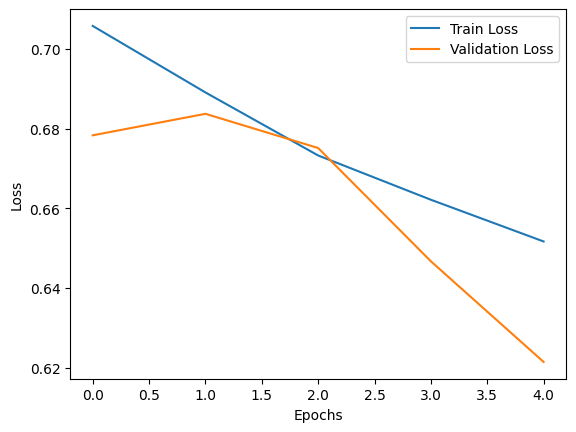

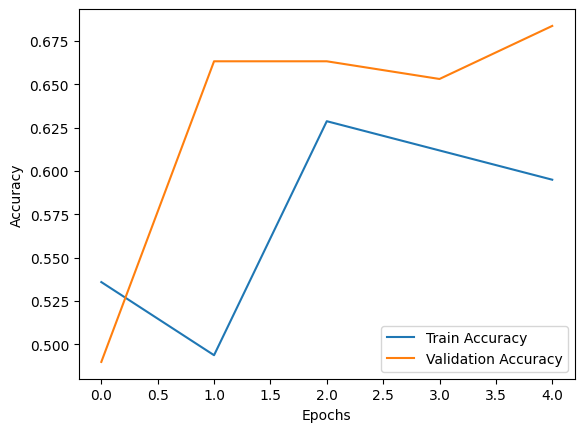

Final Train Loss: 0.6517
Final Validation Loss: 0.6214
Final Train Accuracy: 0.5949
Final Validation Accuracy: 0.6837
Classification Report:
               precision    recall  f1-score   support

Non Accident       0.61      0.96      0.75        52
    Accident       0.88      0.30      0.45        46

    accuracy                           0.65        98
   macro avg       0.74      0.63      0.60        98
weighted avg       0.73      0.65      0.61        98



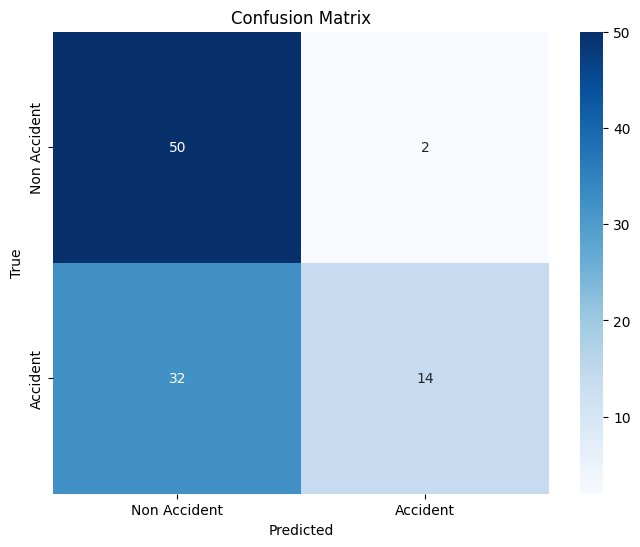

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Step 1: Define the Dataset
class AccidentDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images, self.labels = self.load_images()

    def load_images(self):
        images, labels = [], []
        for label, folder in enumerate(['Non Accident', 'Accident']):
            folder_path = os.path.join(self.data_dir, folder)
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                images.append(img_path)
                labels.append(label)
        return images, labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Step 2: Define the data transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Load and reduce dataset to 30% of the original size
data_dir = '/content/drive/MyDrive/datasetcap2/road_accident_dataset/'
full_train_dataset = AccidentDataset(data_dir + 'train', transform=transform)
train_size = int(0.30 * len(full_train_dataset))
train_dataset, _ = random_split(full_train_dataset, [train_size, len(full_train_dataset) - train_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = AccidentDataset(data_dir + 'val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Step 3: Define the BiLSTM Model
class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]
        out = self.fc(lstm_out)
        return out

# Initialize the model, loss function, and optimizer
input_dim = 128 * 3  # (height * channels)
hidden_dim = 128
output_dim = 1
model = BiLSTMModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Step 4: Train the Model
import time
num_epochs = 5
train_loss, val_loss = [], []
train_acc, val_acc = [], []

start_time = time.time()

for epoch in range(num_epochs):
    # Training loop
    model.train()
    running_loss, correct = 0.0, 0
    for inputs, labels in train_loader:
        if time.time() - start_time > 60:  # Stop training after 1 minute
            break
        inputs = inputs.permute(0, 2, 3, 1).contiguous()  # Reshape to (batch_size, height, width, channels)
        inputs = inputs.view(inputs.size(0), inputs.size(1), -1)  # Reshape to (batch_size, height, height*channels)
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.squeeze()  # Remove the extra dimension
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        preds = torch.round(torch.sigmoid(outputs))
        correct += (preds == labels).sum().item()

    train_loss.append(running_loss/len(train_loader))
    train_acc.append(correct/len(train_loader.dataset))

    # Validation loop
    model.eval()
    val_running_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.permute(0, 2, 3, 1).contiguous()  # Reshape to (batch_size, height, width, channels)
            inputs = inputs.view(inputs.size(0), inputs.size(1), -1)  # Reshape to (batch_size, height, height*channels)
            outputs = model(inputs)
            outputs = outputs.squeeze()  # Remove the extra dimension
            loss = criterion(outputs, labels.float())
            val_running_loss += loss.item()
            preds = torch.round(torch.sigmoid(outputs))
            val_correct += (preds == labels).sum().item()

    val_loss.append(val_running_loss/len(val_loader))
    val_acc.append(val_correct/len(val_loader.dataset))

    if time.time() - start_time > 60:  # Stop training after 1 minute
        break

# Save the model
torch.save(model.state_dict(), '/content/drive/MyDrive/bilstm_train.h5')

# Step 5: Plot Accuracy and Loss Curves
plt.figure()
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Print final accuracy and loss values
print(f"Final Train Loss: {train_loss[-1]:.4f}")
print(f"Final Validation Loss: {val_loss[-1]:.4f}")
print(f"Final Train Accuracy: {train_acc[-1]:.4f}")
print(f"Final Validation Accuracy: {val_acc[-1]:.4f}")
'''
# Step 6: Generate Predictions on the Validation Set
all_preds = []
all_labels = []
images = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        inputs = inputs.view(inputs.size(0), inputs.size(1), -1)
        outputs = model(inputs).squeeze()
        preds = torch.round(torch.sigmoid(outputs))
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        images.extend(inputs.cpu().numpy())

# Step 7: Display a Mix of Accident and Non-Accident Images
accident_images = []
non_accident_images = []
accident_labels = []
non_accident_labels = []
accident_preds = []
non_accident_preds = []

for i in range(len(all_labels)):
    if all_labels[i] == 1 and len(accident_images) < 5:
        accident_images.append(images[i])
        accident_labels.append(all_labels[i])
        accident_preds.append(all_preds[i])
    elif all_labels[i] == 0 and len(non_accident_images) < 5:
        non_accident_images.append(images[i])
        non_accident_labels.append(all_labels[i])
        non_accident_preds.append(all_preds[i])
    if len(accident_images) >= 5 and len(non_accident_images) >= 5:
        break

# Combine the selected images and labels
selected_images = accident_images + non_accident_images
selected_labels = accident_labels + non_accident_labels
selected_preds = accident_preds + non_accident_preds

# Plot the selected images
num_images = len(selected_images)
plt.figure(figsize=(15, 5))
for i in range(num_images):
    img = np.transpose(selected_images[i], (1, 2, 0))  # Convert to HWC format
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # De-normalize
    img = np.clip(img, 0, 1)
    label = "Accident" if selected_labels[i] == 1 else "Non Accident"
    pred_label = "Accident" if selected_preds[i] == 1 else "Non Accident"
    plt.subplot(2, 5, i + 1)  # Create subplot dynamically
    plt.imshow(img)
    plt.title(f"True: {label}\nPred: {pred_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()
'''

# Step 8: Classification Report and Confusion Matrix
report = classification_report(all_labels, all_preds, target_names=['Non Accident', 'Accident'])
print("Classification Report:\n", report)

cm = confusion_matrix(all_labels, all_preds)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non Accident', 'Accident'], yticklabels=['Non Accident', 'Accident'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


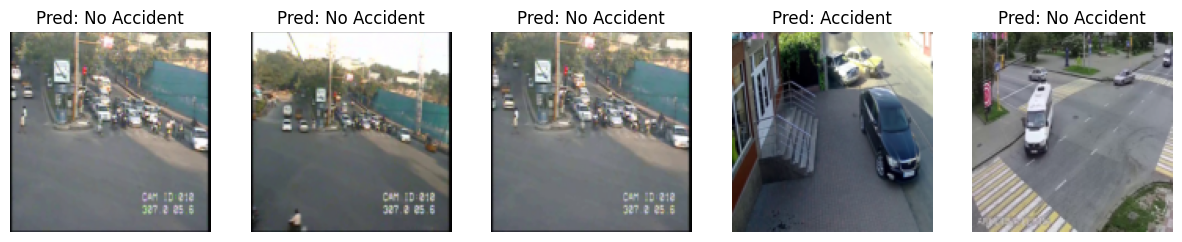

In [18]:
import matplotlib.pyplot as plt

# Step 7: Visualize Some Predictions on the Validation Set
def visualize_predictions(loader, model, num_images=5):
    model.eval()
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    axes = axes.flatten()  # Ensure axes is always a flat array
    img_count = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.permute(0, 2, 3, 1).contiguous()
            inputs = inputs.view(inputs.size(0), inputs.size(1), -1)
            outputs = model(inputs).squeeze()
            preds = torch.round(torch.sigmoid(outputs))

            for j in range(inputs.size(0)):
                if img_count >= num_images:
                    break

                # Convert the input image back to its original shape and scale
                img = inputs[j].view(128, 128, 3).cpu().numpy()
                img = img / img.max()  # Scale the image for visualization

                axes[img_count].imshow(img)
                axes[img_count].set_title(f'Pred: {"Accident" if preds[j] == 1 else "No Accident"}')
                axes[img_count].axis('off')

                img_count += 1

            if img_count >= num_images:
                break

visualize_predictions(val_loader, model)


Classification Report:
               precision    recall  f1-score   support

Non Accident       0.66      0.40      0.50        52
    Accident       0.53      0.76      0.62        46

    accuracy                           0.57        98
   macro avg       0.59      0.58      0.56        98
weighted avg       0.60      0.57      0.56        98



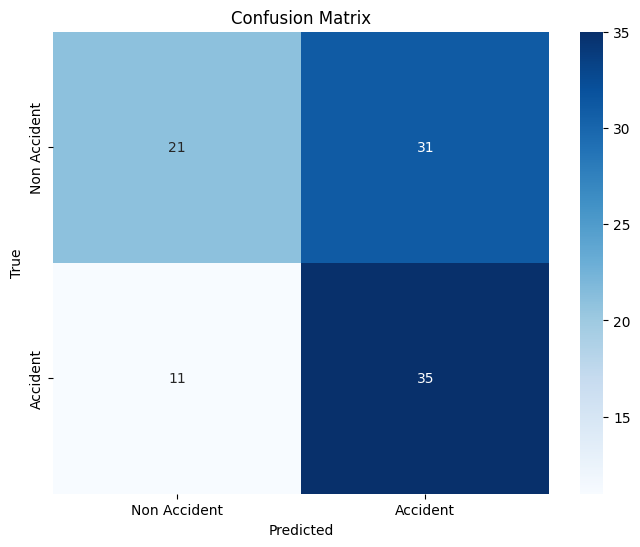

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Step 8: Generate predictions on the validation set
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        inputs = inputs.view(inputs.size(0), inputs.size(1), -1)
        outputs = model(inputs).squeeze()
        preds = torch.round(torch.sigmoid(outputs))
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Step 9: Classification Report
report = classification_report(all_labels, all_preds, target_names=['Non Accident', 'Accident'])
print("Classification Report:\n", report)

# Step 10: Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

# Visualizing the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non Accident', 'Accident'], yticklabels=['Non Accident', 'Accident'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [29]:
import cv2
import torch
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
from IPython.display import display, Image as IPImage

# Step 1: Load the trained model
input_dim = 128 * 3  # (height * channels)
hidden_dim = 128
output_dim = 1
model = BiLSTMModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)
model.load_state_dict(torch.load('/content/drive/MyDrive/bilstm_train.h5'))
model.eval()

# Step 2: Define transformation for video frames
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Step 3: Capture video from file
cap = cv2.VideoCapture('/content/Driver In LA-Area #Crash That Killed 5 Charged With 6 Counts Of Murder.mp4')  # Replace with your video file path

#cap = cv2.VideoCapture('https://www.youtube.com/shorts/o_gWJX1EyWY')
# Step 4: Prepare to save the output video
output_path = '/content/output_video.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

# Step 5: Process each frame from the video stream
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the frame to a PIL image
    img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    # Apply the transformation
    img_transformed = transform(img)

    # Reshape and prepare the image for the model
    img_transformed = img_transformed.unsqueeze(0)  # Add batch dimension
    img_transformed = img_transformed.permute(0, 2, 3, 1).contiguous()
    img_transformed = img_transformed.view(img_transformed.size(0), img_transformed.size(1), -1)

    # Step 6: Make a prediction using the model
    with torch.no_grad():
        output = model(img_transformed).squeeze()
        pred = torch.round(torch.sigmoid(output)).item()

    # Step 7: Display the prediction on the video feed
    label = "Accident" if pred == 1 else "No Accident"
    color = (0, 0, 255) if pred == 1 else (0, 255, 0)  # Red for Accident, Green for No Accident
    cv2.putText(frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

    # Write the frame to the output video
    out.write(frame)

# Step 8: Release the video capture and writer
cap.release()
out.release()

# Step 9: Display the output video
from IPython.display import display, HTML
display(HTML(f"""
<video width="640" height="480" controls>
  <source src="{output_path}" type="video/mp4">
</video>
"""))


CONSIDER FROM **HERE** **bold text**

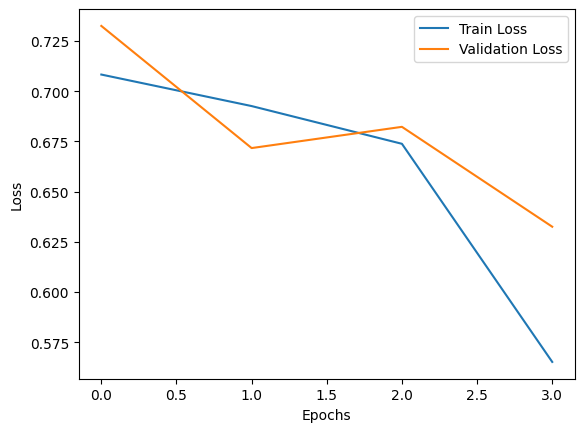

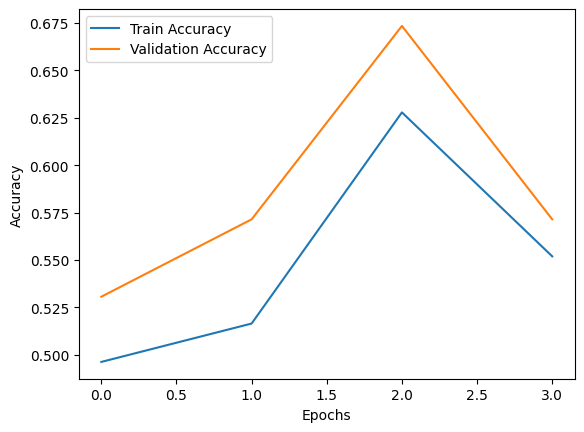

Final Train Loss: 0.5652
Final Validation Loss: 0.6326
Final Train Accuracy: 0.5519
Final Validation Accuracy: 0.5714
Classification Report:
               precision    recall  f1-score   support

Non Accident       0.61      0.96      0.75        52
    Accident       0.88      0.30      0.45        46

    accuracy                           0.65        98
   macro avg       0.74      0.63      0.60        98
weighted avg       0.73      0.65      0.61        98



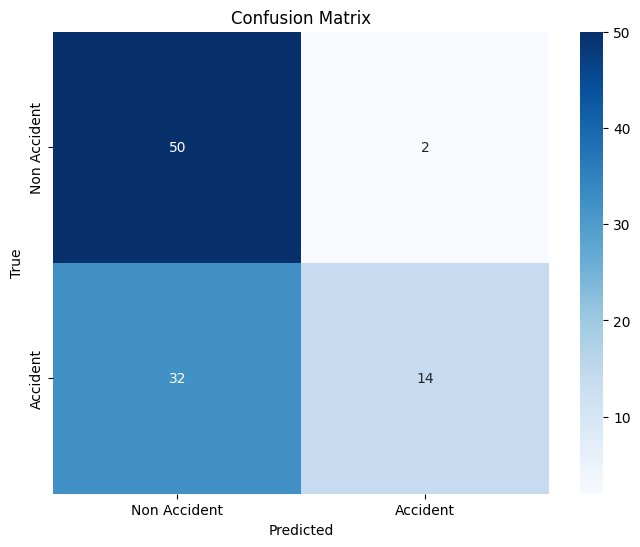

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Step 1: Define the Dataset
class AccidentDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images, self.labels = self.load_images()

    def load_images(self):
        images, labels = [], []
        for label, folder in enumerate(['Non Accident', 'Accident']):
            folder_path = os.path.join(self.data_dir, folder)
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                images.append(img_path)
                labels.append(label)
        return images, labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Step 2: Define the data transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Load and reduce dataset to 30% of the original size
data_dir = '/content/drive/MyDrive/datasetcap2/road_accident_dataset/'
full_train_dataset = AccidentDataset(data_dir + 'train', transform=transform)
train_size = int(0.50 * len(full_train_dataset))
train_dataset, _ = random_split(full_train_dataset, [train_size, len(full_train_dataset) - train_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = AccidentDataset(data_dir + 'val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Step 3: Define the BiLSTM Model
class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]
        out = self.fc(lstm_out)
        return out

# Initialize the model, loss function, and optimizer
input_dim = 128 * 3  # (height * channels)
hidden_dim = 128
output_dim = 1
model = BiLSTMModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Step 4: Train the Model
import time
num_epochs = 5
train_loss, val_loss = [], []
train_acc, val_acc = [], []

start_time = time.time()

for epoch in range(num_epochs):
    # Training loop
    model.train()
    running_loss, correct = 0.0, 0
    for inputs, labels in train_loader:
        if time.time() - start_time > 60:  # Stop training after 1 minute
            break
        inputs = inputs.permute(0, 2, 3, 1).contiguous()  # Reshape to (batch_size, height, width, channels)
        inputs = inputs.view(inputs.size(0), inputs.size(1), -1)  # Reshape to (batch_size, height, height*channels)
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.squeeze()  # Remove the extra dimension
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        preds = torch.round(torch.sigmoid(outputs))
        correct += (preds == labels).sum().item()

    train_loss.append(running_loss/len(train_loader))
    train_acc.append(correct/len(train_loader.dataset))

    # Validation loop
    model.eval()
    val_running_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.permute(0, 2, 3, 1).contiguous()  # Reshape to (batch_size, height, width, channels)
            inputs = inputs.view(inputs.size(0), inputs.size(1), -1)  # Reshape to (batch_size, height, height*channels)
            outputs = model(inputs)
            outputs = outputs.squeeze()  # Remove the extra dimension
            loss = criterion(outputs, labels.float())
            val_running_loss += loss.item()
            preds = torch.round(torch.sigmoid(outputs))
            val_correct += (preds == labels).sum().item()

    val_loss.append(val_running_loss/len(val_loader))
    val_acc.append(val_correct/len(val_loader.dataset))

    if time.time() - start_time > 60:  # Stop training after 1 minute
        break

# Save the model
torch.save(model.state_dict(), '/content/drive/MyDrive/bilstm_train.h5')

# Step 5: Plot Accuracy and Loss Curves
plt.figure()
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Print final accuracy and loss values
print(f"Final Train Loss: {train_loss[-1]:.4f}")
print(f"Final Validation Loss: {val_loss[-1]:.4f}")
print(f"Final Train Accuracy: {train_acc[-1]:.4f}")
print(f"Final Validation Accuracy: {val_acc[-1]:.4f}")



# Step 8: Classification Report and Confusion Matrix
report = classification_report(all_labels, all_preds, target_names=['Non Accident', 'Accident'])
print("Classification Report:\n", report)

cm = confusion_matrix(all_labels, all_preds)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non Accident', 'Accident'], yticklabels=['Non Accident', 'Accident'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


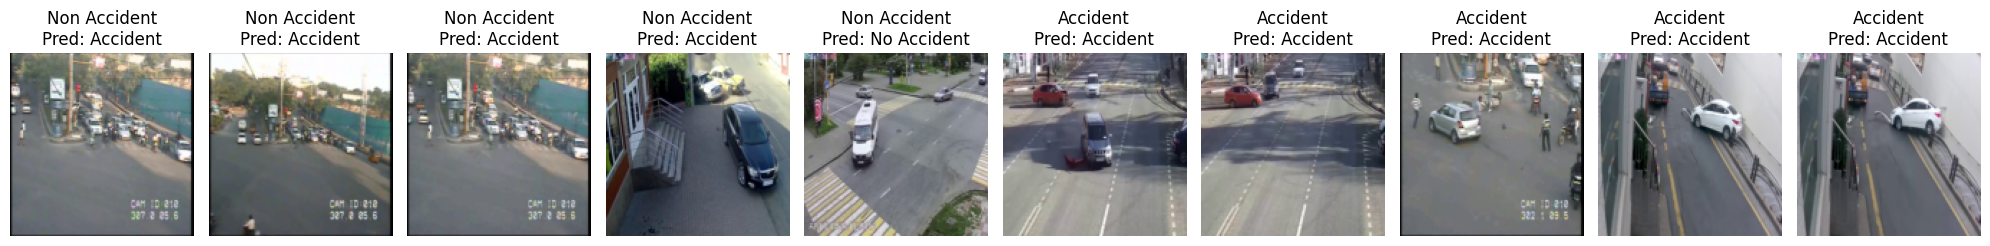

In [39]:
import matplotlib.pyplot as plt

# Function to visualize 5 Accident and 5 Non Accident images from the validation set
def visualize_mixed_predictions(val_loader, model, num_images_per_class=5):
    model.eval()
    total_images = num_images_per_class * 2  # Total number of images to display
    fig, axes = plt.subplots(1, total_images, figsize=(20, 5))
    axes = axes.flatten()  # Ensure axes is always a flat array

    accident_count = 0
    non_accident_count = 0
    img_count = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.permute(0, 2, 3, 1).contiguous()
            inputs = inputs.view(inputs.size(0), inputs.size(1), -1)
            outputs = model(inputs).squeeze()
            preds = torch.round(torch.sigmoid(outputs))

            for j in range(inputs.size(0)):
                if img_count >= total_images:
                    break

                if labels[j].item() == 1 and accident_count < num_images_per_class:
                    # Accident image
                    img = inputs[j].view(128, 128, 3).cpu().numpy()
                    img = img / img.max()  # Scale the image for visualization
                    axes[img_count].imshow(img)
                    axes[img_count].set_title(f'Accident\nPred: {"Accident" if preds[j] == 1 else "No Accident"}')
                    axes[img_count].axis('off')
                    accident_count += 1
                    img_count += 1

                elif labels[j].item() == 0 and non_accident_count < num_images_per_class:
                    # Non Accident image
                    img = inputs[j].view(128, 128, 3).cpu().numpy()
                    img = img / img.max()  # Scale the image for visualization
                    axes[img_count].imshow(img)
                    axes[img_count].set_title(f'Non Accident\nPred: {"Accident" if preds[j] == 1 else "No Accident"}')
                    axes[img_count].axis('off')
                    non_accident_count += 1
                    img_count += 1

            if img_count >= total_images:
                break

    plt.tight_layout()
    plt.show()

visualize_mixed_predictions(val_loader, model)
